**Getting started**
1. If the python distribution Anaconda is installed, likely only the following dependencies are missing:  
  `pip install h5py, seaborn`
2. Download the data from [here](https://doi.org/10.5281/zenodo.1204501), unzip it and copy the `*.h5` file(s) into the same folder as this notebook.
3. Make sure the folder `scripts` is also in the same folder as this notebook.

In [1]:
import h5py
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from scripts.spectrum import wavelength_to_rgb
from scripts.h5py_helper import read_hdf5_data, print_hfd5_directory, nan2zero

%matplotlib inline 
sns.set_style("whitegrid", {'axes.grid' : False})

Define full path to HDF5 data file and list datafolders in the file:

In [2]:
path = "BadenSchubert2013_SpectraPics.h5"

keys = h5py.File(path, 'r').keys()
list(keys)

['dataset_2012_03_06b',
 'dataset_2012_03_06c',
 'dataset_2012_03_09',
 'opsin_spectra']

In [3]:
print_hdf5_directory(path)

dataset_2012_03_06b
   |  info='Di, 6. Mrz 2012 13:39:51, w cap, 200ms integration time'
   `--spectral_img(50, 50, 2048)
dataset_2012_03_06c
   |  info='Di, 6. Mrz 2012 13:29:55, w/o cap, 25 ms integration time'
   `--spectral_img(50, 50, 2048)
dataset_2012_03_09
   |  info='Fr, 9. Mrz 2012 14:09:52'
   `--spectral_img(80, 80, 2048)
opsin_spectra
   |  info='spectral sensitivity curves for mice and humans, and x scali'
   |--human_Spect440(2048,)
   |--human_Spect535(2048,)
   |--human_Spect565(2048,)
   |--mouse_Spect360(2048,)
   |--mouse_Spect511(2048,)
   `--wavelengths(2048,)


Define a dataset to analyse and load spectral image data. The data is a 80x80 array of spectra (each 2048 data points long). To display the resulting image in the correct orientation, the data need to be transposed (exchange x and y).

In [10]:
dataset_name = "dataset_2012_03_09"
spectral_img = dict(h5py.File(path, 'r')[dataset_name].items())["spectral_img"]
spectral_img = np.transpose(spectral_img, (1,0,2))
print(spectral_img.shape)

(80, 80, 2048)


Load opsin spectra for mice and man as well as scaling of spectral data. Plot the spectra.

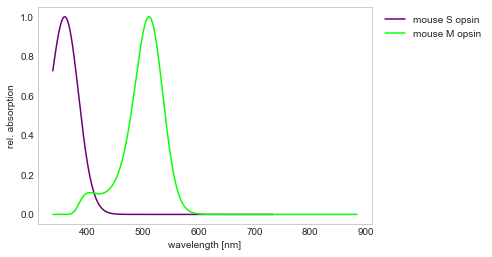

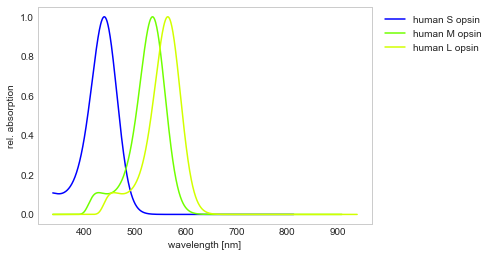

In [11]:
wavelengths  = dict(h5py.File(path, 'r')["opsin_spectra"].items())["wavelengths"]
mouse_scone  = dict(h5py.File(path, 'r')["opsin_spectra"].items())["mouse_Spect360"]
mouse_mcone  = dict(h5py.File(path, 'r')["opsin_spectra"].items())["mouse_Spect511"]
human_scone  = dict(h5py.File(path, 'r')["opsin_spectra"].items())["human_Spect440"]
human_mcone  = dict(h5py.File(path, 'r')["opsin_spectra"].items())["human_Spect535"]
human_lcone  = dict(h5py.File(path, 'r')["opsin_spectra"].items())["human_Spect565"]

plt.figure(1)
plt.plot(wavelengths, mouse_scone, color=wavelength_to_rgb(360), label="mouse S opsin")
plt.plot(wavelengths, mouse_mcone, color=wavelength_to_rgb(511), label="mouse M opsin")
plt.gca().set(xlabel="wavelength [nm]", ylabel="rel. absorption")     
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

plt.figure(2)
plt.plot(wavelengths, human_scone, color=wavelength_to_rgb(440), label="human S opsin")
plt.plot(wavelengths, human_mcone, color=wavelength_to_rgb(535), label="human M opsin")
plt.plot(wavelengths, human_lcone, color=wavelength_to_rgb(565), label="human L opsin")
plt.gca().set(xlabel="wavelength [nm]", ylabel="rel. absorption")     
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

This is how one can access the spectrum for each point in the spectral image:

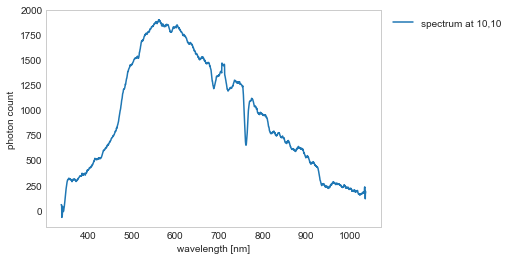

In [12]:
temp_spect = spectral_img[10][10]

plt.plot(wavelengths, temp_spect, label="spectrum at 10,10")
plt.gca().set(xlabel="wavelength [nm]", ylabel="photon count")     
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

Functions for generating mouse (or human) views of the spectral image data:

In [13]:
def getPixel(spect, x, y, opsin_spect, curr_a_max):
    """ Multiply spectrum at pixel x,y with opsin absorption spectrum and
        return the area under the curve as well as the maximal area until
        this point. 
    """    
    s = spect[x][y] *opsin_spect
    s = nan2zero(s)
    
    # ... determine area under the curve (AUC) and remember value 
    # if larger than the values before (for normalisation) 
    #
    area  = np.trapz(s)
    a_max = max(curr_a_max, area)
    
    # Return AUC and currently maximal AUC
    #
    return area, a_max

def calcImage(sp_img, sp_cones):
    """ Calculate RGB image based on the spectral image and the list of 
        cone opsin spectra
    """
    i_max      = [0]*3
    dx, dy, dS = sp_img.shape
    img        = np.zeros((dx, dy, 3))
    rgb_img    = np.zeros((dy, dx, 3), dtype=np.uint8)

    # Determine the excitation of the different opsins for each pixel
    #
    for iCh, sp_cone in enumerate(sp_cones):
        if not(sp_cone is None): 
            for x in range(dx):
                for y in range(dy):
                    img[x][y][iCh], i_max[iCh] = getPixel(sp_img, x, y, sp_cone, i_max[iCh])
        
    # Copy into RGB image
    #
    for iCh, sp_cone in enumerate(sp_cones):
        if not(sp_cone is None): 
            rgb_img[:,:,iCh] = img[:,:,iCh] /i_max[iCh] *255
    
    return rgb_img

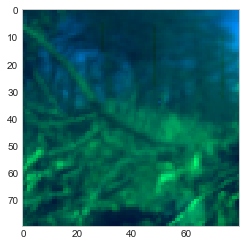

In [14]:
img_mouse = calcImage(spectral_img, [None, mouse_mcone, mouse_scone])
plt.imshow(img_mouse)
plt.show()

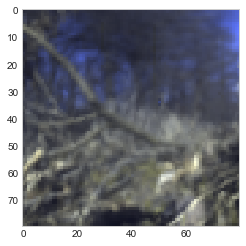

In [15]:
img_human = calcImage(spectral_img, [human_lcone, human_mcone, human_scone])
plt.imshow(img_human)
plt.show()